In [263]:
from strava import StravaAPI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytz import timezone, UnknownTimeZoneError
from geopy.geocoders import Nominatim
import seaborn as sns
import warnings
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from langchain.chat_models import ChatOpenAI


warnings.filterwarnings(action='ignore')

In [93]:
def cast_day_part(hour):
    if hour in range(0, 10):
        return 'Morning'
    if hour in range(10, 17):
        return 'Mid-Day'
    if hour in range(17, 24):
        return 'Evening'

In [206]:
def pull_geo(row, level):
    lat, long = row['start_lat'], row['start_long']
    if np.isnan(lat):
        return 'Indoor'
    geolocator = Nominatim(user_agent='geo_api')
    location = geolocator.reverse((str(lat), str(long)))
    result = location.raw.get('address').get('city')
    if result is None:
        result = location.raw.get('address').get('town')
        if result is None:
            result = location.raw.get('address').get('village')
    return result

In [207]:
def map_timezone(tz_str):
    try:
        return timezone(tz_str)
    except UnknownTimeZoneError:
        if tz_str == '(GMT-05:00) America/Atikokan':
            return timezone('America/Toronto')  
        elif tz_str == '(GMT-05:00) America/New_York':
            return timezone('America/New_York')  
        elif tz_str == '(GMT-04:00) America/Anguilla':
            return timezone('America/Puerto_Rico')  
        elif tz_str == '(GMT-07:00) America/Phoenix':
            return timezone('America/Phoenix')  
        elif tz_str == '(GMT-06:00) America/Chicago':
            return timezone('America/Chicago')  
        elif tz_str == '(GMT+01:00) Europe/Rome':
            return timezone('Europe/Rome')  
        elif tz_str == '(GMT+02:00) Africa/Blantyre':
            return timezone('Africa/Blantyre')  
        else:
            return timezone('UTC') 

In [226]:
strava = StravaAPI(client_id=None, client_secret=None)
df = strava.read_data()
df['start_date'] = pd.to_datetime(df['start_date'])  # Ensure start_date is a datetime object
df['start_date_local'] = df.apply(
    lambda row: row['start_date'].tz_convert(map_timezone(row['timezone'])), axis=1
)
df = df[df['date_str'] >= '2025-01-01'].sort_values('date_str')
df['mile_cat'] = df['distance_miles'].round()
df['month'] = df['date_str'].apply(lambda x: pd.Timestamp(x).date().month)
df['week'] = df['date_str'].apply(lambda x: pd.Timestamp(x).weekofyear)
df['week_day'] = df['date_str'].apply(lambda x: pd.Timestamp(x).weekday)
df['hour'] = df['start_date_local'].apply(lambda x: pd.Timestamp(x).hour)
df['day_part'] = df['hour'].apply(cast_day_part)
df['city'] = df.apply(lambda row: pull_geo(row, level='city'),axis=1)

In [189]:
df[df['date_str'] == '2025-12-24'][['start_lat', 'start_long']]

,start_lat,start_long
11,40.725582,-73.978495
12,40.725585,-73.978428


In [204]:
geolocator = Nominatim(user_agent='geo_api')
location = geolocator.reverse((str(42.235716), str(-74.29929)))
result = location.raw.get('address')

In [205]:
result

{'house_number': '61',
 'road': 'Evergreen Drive',
 'hamlet': 'Town of Jewett',
 'village': 'Town of Hunter',
 'county': 'Greene County',
 'state': 'New York',
 'ISO3166-2-lvl4': 'US-NY',
 'postcode': '12442',
 'country': 'United States',
 'country_code': 'us'}

In [200]:
df['city'].unique()

array(['Indoor', 'City of New York', 'Shaker Heights', 'Scottsdale',
       'Clayton', None, 'Evanston', 'Siracusa', 'Town of Southold',
       'Kansas City', 'Cleveland'], dtype=object)

In [202]:
df[df['date_str'] == '2025-07-18'][['start_lat', 'start_long']]

,start_lat,start_long
297,42.235716,-74.29929


In [96]:
df['day_part'].unique()

array(['Mid-Day', 'Morning', 'Evening'], dtype=object)

In [97]:
df['hour'].unique()

array([15,  8, 13,  7, 14, 18,  9, 16, 12, 11, 19, 10, 17, 20, 23,  3, 22,
       21,  0])

In [307]:
df['date_str'].max()

'2025-12-24'

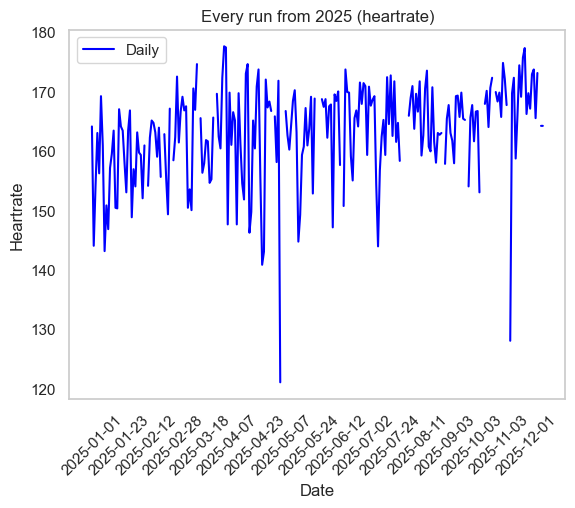

In [331]:

plt.plot(df['average_heartrate'].values, color='blue')
# plt.plot(df['average_heartrate'].rolling(7).mean().values, color='red')
x_ticks = range(0, len(df), 15)  # every 10th index
x_labels = df['date_str'].iloc[::15]  # assumes 'date' is datetime
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=45)
plt.title("Every run from 2025 (heartrate)")
plt.xlabel('Date')
plt.ylabel('Heartrate')
plt.grid(False)
plt.legend(['Daily', 'Rolling Average (n=7)'])
plt.show()

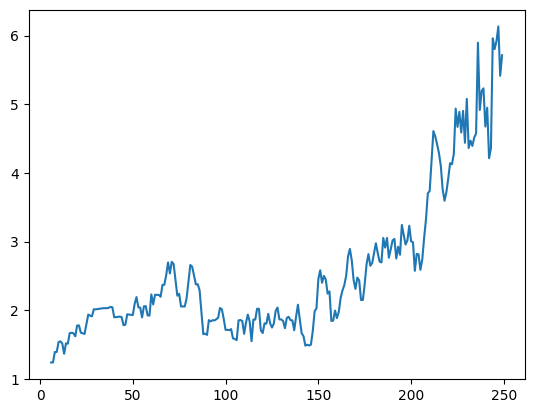

In [34]:
plt.plot(df['distance_miles'].rolling(7).mean().values)

<Axes: xlabel='month'>

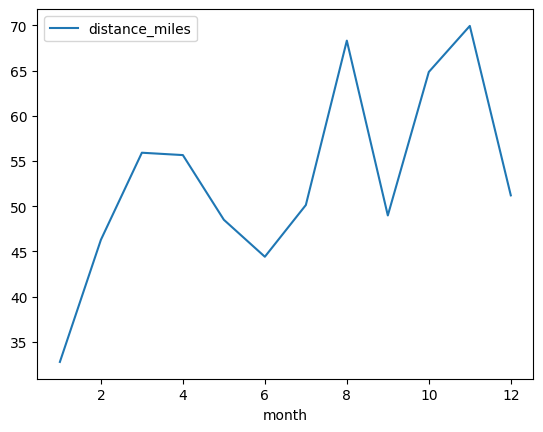

In [18]:
df.groupby('month').agg({'distance_miles':'sum'}).plot()

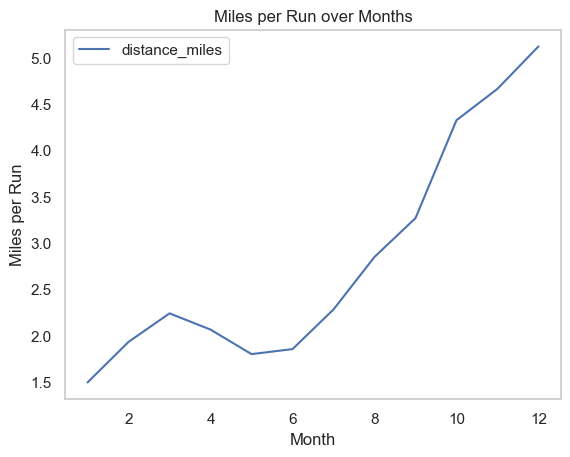

In [327]:
df.groupby('month').agg({'distance_miles':'mean'}).plot()
plt.xlabel('Month')
plt.ylabel("Miles per Run")
plt.grid(False)
plt.title("Miles per Run over Months")
plt.show()

<BarContainer object of 12 artists>

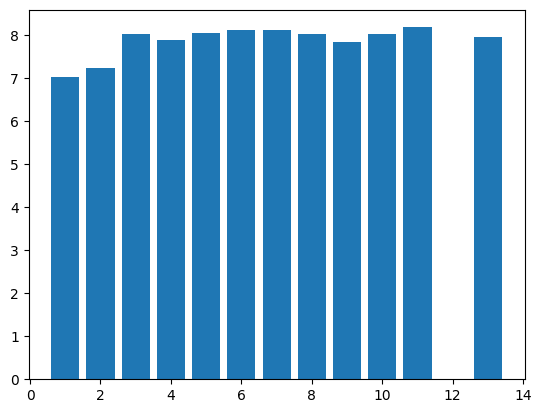

In [51]:
paces_average = df.groupby('mile_cat').agg({'pace':'mean'}).reset_index()

plt.bar(x=paces_average['mile_cat'], height=paces_average['pace'])

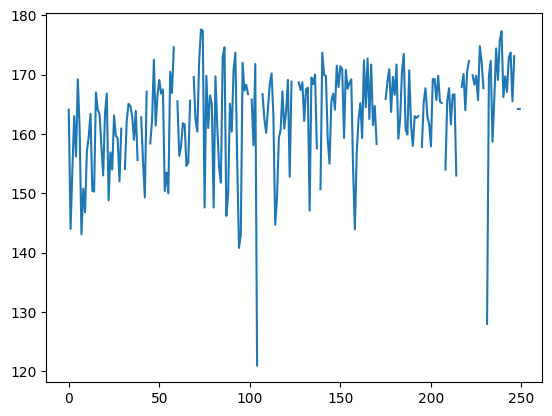

In [53]:
plt.plot(df['average_heartrate'].values)
plt.xlabel()

In [227]:
day_parts = df.groupby('day_part').agg({'distance_miles':('sum', 'mean', 'count'), 'pace':('mean')}).reset_index()

In [228]:
day_parts

day_part distance_miles                      pace
                      sum      mean count      mean
0  Evening     221.873440  3.311544    67  7.803841
1  Mid-Day     224.669796  2.340310    96  7.402134
2  Morning     190.462887  2.189229    87  7.225363

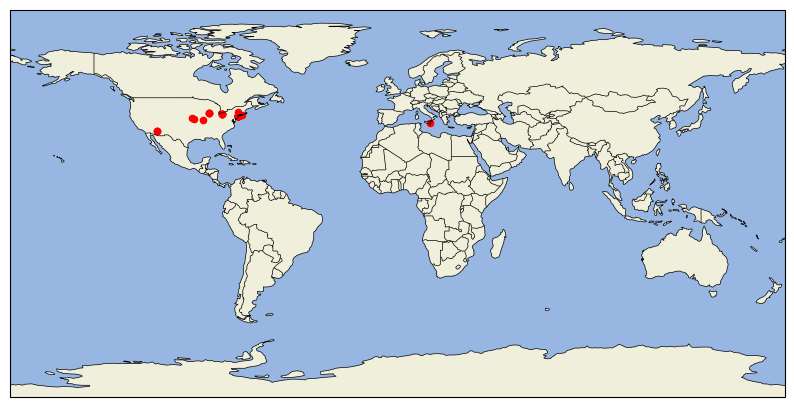

In [211]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

points = df[['start_lat', 'start_long']].values

lats = [p[0] for p in points]
lons = [p[1] for p in points]

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

ax.scatter(
    lons,
    lats,
    color="red",
    s=20,
    transform=ccrs.PlateCarree(),
)

plt.show()


In [333]:
df['city'].unique()

array(['Indoor', 'City of New York', 'Shaker Heights', 'Scottsdale',
       'Clayton', 'Town of Hunter', 'Evanston', 'Siracusa',
       'Town of Southold', 'Kansas City', None, 'Cleveland'], dtype=object)

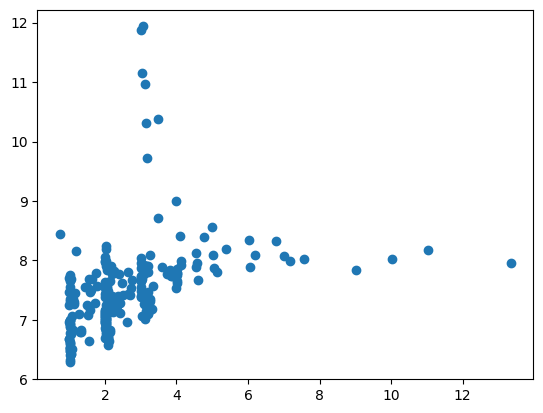

In [214]:
plt.scatter(df['distance_miles'], df['pace'])

In [ ]:
df['day']

<Axes: xlabel='day_part', ylabel='distance_miles'>

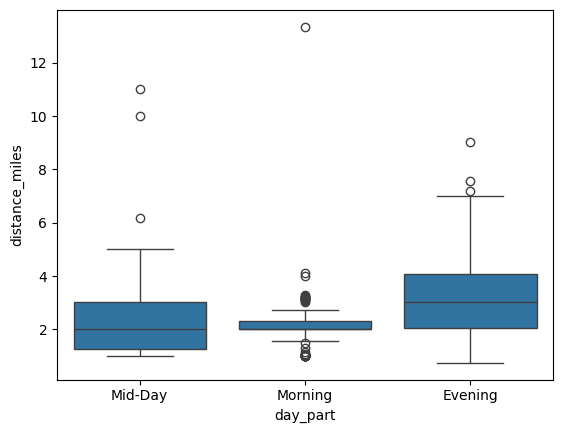

In [218]:
sns.boxplot(data=df, x='day_part', y='distance_miles')

In [221]:
day_parts

day_part distance_miles                
                      sum      mean count
0  Evening     221.873440  3.311544    67
1  Mid-Day     224.669796  2.340310    96
2  Morning     190.462887  2.189229    87

<Axes: title={'center': 'Average Pace'}, xlabel='day_part', ylabel='Min / Mile'>

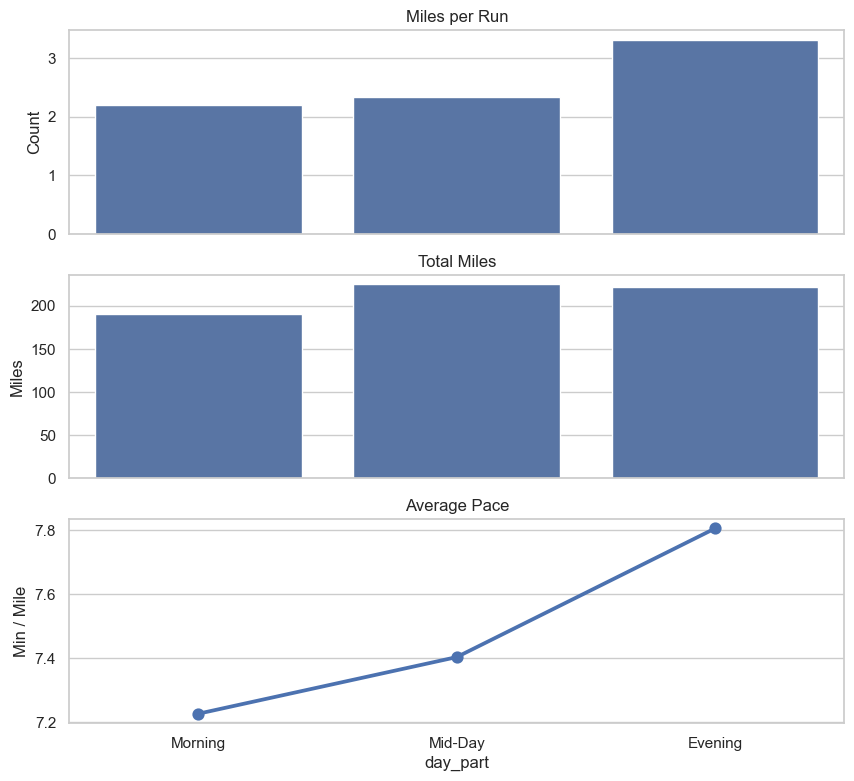

In [235]:

order = ['Morning', 'Mid-Day', 'Evening']

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(10, 9),
    sharex=True
)

# ------------------
# Run Count
# ------------------
sns.barplot(
    ax=axes[0],
    data=day_parts,
    x="day_part",
    y=('distance_miles', 'mean'),
    order=order
)
axes[0].set_title("Miles per Run")
axes[0].set_ylabel("Count")

# ------------------
# Total Miles
# ------------------
sns.barplot(
    ax=axes[1],
    data=day_parts,
    x="day_part",
    y=('distance_miles', 'sum'),
    order=order
)
axes[1].set_title("Total Miles")
axes[1].set_ylabel("Miles")

# ------------------
# Average Pace
# ------------------
sns.pointplot(
    ax=axes[2],
    data=day_parts,
    x="day_part",
    y=('pace', 'mean'),
    order=order,
    markers="o",
    linestyles="-"
)
axes[2].set_title("Average Pace")
axes[2].set_ylabel("Min / Mile")
axes[2]

In [248]:
artist_counts = df.groupby('artist').agg({'song_otd':'count'}).reset_index()

In [254]:
top_10_artists = artist_counts.sort_values('song_otd', ascending=False).head(10)

In [255]:
top_10_artists

,artist,song_otd
51,Kanye West,9
2,ASAP Rocky,5
104,Wiz Khalifa,4
17,Chance the Rapper,4
30,Drake,4
62,Mac Miller,4
76,Playboi Carti,3
58,Lil Uzi Vert,3
55,Kid Cudi,3
52,Kendrick Lamar,3


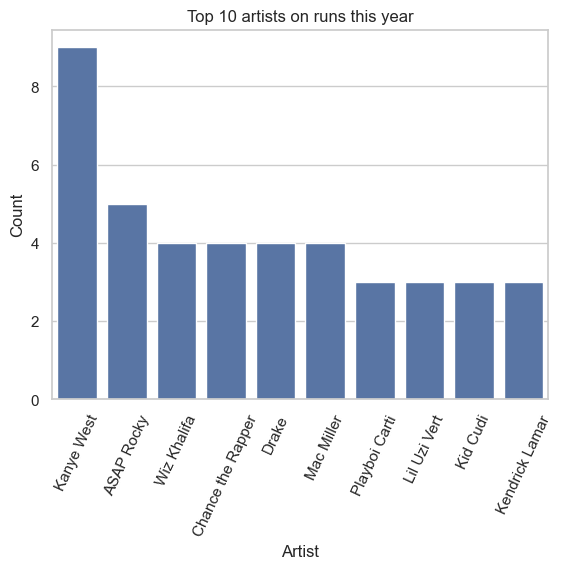

In [334]:
sns.barplot(data=top_10_artists, x='artist', y='song_otd')
plt.xticks(rotation=65)
plt.xlabel("Artist")
plt.ylabel("Count")
plt.title("Top 10 artists on runs this year")
plt.show()

In [335]:
len(tracks)

174

In [265]:
df['description_music'].unique()

array([nan, ' Best Day Ever by Mac Miller', ' Ladders by Mac Miller',
       ' Fancy Footwork by Chromeo', ' Alright by Kendrick Lamar',
       ' Kids by MGMT', ' Like Him by Tyler the Creator',
       ' She’s a Lady by Tom Jones',
       ' Everything I Love by Morgan Wallen',
       ' I. The Worst Guys by Childish Gambino and Chance the Rapper',
       ' K Pop by Playboi Carti',
       ' Sally, When The Wine Runs Out by ROLE MODEL',
       ' HIGHJACK by ASAP Rocky', ' Idk Why by Gunna',
       ' Nightrain by Guns n Roses', ' Good News by Mac Miller',
       '. Wave Gods by ASAP Rocky ft. Nas', ' All Over the World by ELO',
       ' Holy Ghost by ASAP Rocky', ' LOVE by Kid Cudi',
       ' Listen To The Music by The Doobie Brothers',
       ' On My Block by Scarface',
       ' For Once In My Life by Stevie Wonder',
       ' Better Things by ASAP Rocky', ' Animal by Neon Trees',
       ' Slide by Frank Ocean', ' No Sleep by Wiz Khalifa',
       '. Spaceship by Kanye West',
       ' Waiti

In [264]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-5.1",
    max_completion_tokens=16000,
    streaming=True,
)

WARNING! max_completion_tokens is not default parameter.
                    max_completion_tokens was transferred to model_kwargs.
                    Please confirm that max_completion_tokens is what you intended.


In [266]:
vals = df['description_music'].values

In [268]:
prompt = f"""
I need you to do only one thing: take the following list of songs and artists, clean them if they have the wrong name.
And then return a python matrix where first value is song, second value is artist.

Here is the list:

{vals}
"""

test = llm.invoke(prompt)

In [277]:
print(test.content[25:])

["Best Day Ever", "Mac Miller"],
    ["Ladders", "Mac Miller"],
    ["Fancy Footwork", "Chromeo"],
    ["Alright", "Kendrick Lamar"],
    ["Kids", "MGMT"],
    ["Like Him", "Tyler, The Creator"],
    ["She's a Lady", "Tom Jones"],
    ["Everything I Love", "Morgan Wallen"],
    ["I. The Worst Guys", "Childish Gambino ft. Chance the Rapper"],
    ["K Pop", "Playboi Carti"],
    ["Sally, When the Wine Runs Out", "ROLE MODEL"],
    ["Hella Hoes (HIGHJACK)", "A$AP Rocky"],  # best guess for "HIGHJACK"
    ["IDK Why", "Gunna"],
    ["Nightrain", "Guns N' Roses"],
    ["Good News", "Mac Miller"],
    ["Wave Gods", "A$AP Rocky ft. Nas"],
    ["All Over the World", "Electric Light Orchestra"],
    ["Holy Ghost", "A$AP Rocky"],
    ["LOVE.", "Kid Cudi"],  # assuming Cudi track "LOVE."
    ["Listen to the Music", "The Doobie Brothers"],
    ["On My Block", "Scarface"],
    ["For Once in My Life", "Stevie Wonder"],
    ["Better Things", "A$AP Rocky"],
    ["Animal", "Neon Trees"],
    ["Slide", "

In [278]:
tracks = [["Best Day Ever", "Mac Miller"],
    ["Ladders", "Mac Miller"],
    ["Fancy Footwork", "Chromeo"],
    ["Alright", "Kendrick Lamar"],
    ["Kids", "MGMT"],
    ["Like Him", "Tyler, The Creator"],
    ["She's a Lady", "Tom Jones"],
    ["Everything I Love", "Morgan Wallen"],
    ["I. The Worst Guys", "Childish Gambino ft. Chance the Rapper"],
    ["K Pop", "Playboi Carti"],
    ["Sally, When the Wine Runs Out", "ROLE MODEL"],
    ["Hella Hoes (HIGHJACK)", "A$AP Rocky"],  # best guess for "HIGHJACK"
    ["IDK Why", "Gunna"],
    ["Nightrain", "Guns N' Roses"],
    ["Good News", "Mac Miller"],
    ["Wave Gods", "A$AP Rocky ft. Nas"],
    ["All Over the World", "Electric Light Orchestra"],
    ["Holy Ghost", "A$AP Rocky"],
    ["LOVE.", "Kid Cudi"],  # assuming Cudi track "LOVE."
    ["Listen to the Music", "The Doobie Brothers"],
    ["On My Block", "Scarface"],
    ["For Once in My Life", "Stevie Wonder"],
    ["Better Things", "A$AP Rocky"],
    ["Animal", "Neon Trees"],
    ["Slide", "Frank Ocean"],
    ["No Sleep", "Wiz Khalifa"],
    ["Spaceship", "Kanye West"],
    ["Waiting on the World to Change", "John Mayer"],
    ["Pop Thieves (Make It Feel Good)", "Childish Gambino"],
    ["Everybody Talks", "Neon Trees"],
    ["Derek Fisher", "Gunna"],
    ["Juice", "Chance the Rapper"],
    ["Sad Machine", "Porter Robinson"],
    ["Digital Love", "Daft Punk"],
    ["I Love You, I'm Sorry", "Gracie Abrams"],
    ["Dance The Night", "Dua Lipa"],
    ["Don't Stop Me Now", "Queen"],
    ["Coming Over", "Dillon Francis"],
    ["Vienna", "Billy Joel"],
    ["Borderline", "Tame Impala"],
    ["Lost in the World", "Kanye West"],
    ["Everything I Love", "Morgan Wallen"],
    ["A Milli", "Lil Wayne"],
    ["L$D (Lovesick)", "A$AP Rocky"],  # "Lovesick by ASAP Rocky"
    ["Roses", "The Chainsmokers"],
    ["Nothin' on You", "B.o.B ft. Bruno Mars"],
    ["Love Me Not", "Ravyn Lenae"],
    ["So Good", "B.o.B"],
    ["Levels", "Avicii"],
    ["Guess Who's Back", "Rakim"],
    ["Hard Times", "Paramore"],
    ["Pursuit of Happiness", "Kid Cudi"],
    ["Runaway", "Kanye West"],
    ["Flashed Junk Mind", "Milky Chance"],
    ["92 Explorer", "Post Malone"],
    ["Gravity", "Brent Faiyaz"],
    ["The Sweet Escape", "Gwen Stefani ft. Akon"],
    ["Work", "Gang Starr"],
    ["Prom Night", "Chance the Rapper"],
    ["Under The Weather", "Brent Faiyaz"],
    ["In Vein", "The Weeknd"],  # appears on Rick Ross track
    ["Hella Hoes (HIGHJACK Remix)", "A$AP Rocky"],  # best guess
    ["Kids", "MGMT"],
    ["Take It Off", "FISHER"],
    ["So High", "Wiz Khalifa"],
    ["Borderline", "Tame Impala"],
    ["Stolen Dance", "Milky Chance"],
    ["Hip Hop Saved My Life", "Lupe Fiasco"],
    ["Patty Cake", "Kodak Black"],
    ["R.I.P. (RATHER LIE?)", "Playboi Carti"],  # unclear, kept close to given
    ["Wouldn't It Be Nice", "The Beach Boys"],
    ["Stargirl Interlude", "The Weeknd ft. Lana Del Rey"],
    ["Dark Fantasy", "Kanye West"],
    ["Ventura Highway", "America"],
    ["Dead Presidents II", "JAY-Z"],
    ["What They Do", "The Roots"],
    ["C.R.E.A.M.", "Wu-Tang Clan"],
    ["I Heard It Through the Grapevine", "Marvin Gaye"],
    ["Thank God", "Travis Scott"],
    ["That's Life", "Mac Miller"],
    ["deja vu", "Olivia Rodrigo"],
    ["Waterboy", "Tobi Lou"],
    ["Beat It", "Michael Jackson"],
    ["FACE", "BROCKHAMPTON"],
    ["Succession Main Title Theme", "Nicholas Britell"],
    ["It's a Great Day to Be Alive", "Travis Tritt"],
    ["Poetic Justice", "Kendrick Lamar"],
    ["No More Mr. Nice Guy", "Alice Cooper"],
    ["Tumbling Dice", "The Rolling Stones"],
    ["Vacay", "Aminé"],
    ["Champain and Vacay", "Travis Scott"],  # best guess, kept as-is
    ["Pacifier", "Young Thug"],
    ["Sleep All Day", "Sean Kingston"],
    ["The Bigger Picture", "Lil Baby"],
    ["Californication", "Red Hot Chili Peppers"],
    ["Ice Melts", "Drake ft. Young Thug"],
    ["POP STAR", "DaBaby"],
    ["Impossible Year", "Panic! At The Disco"],
    ["Had Enough", "Don Toliver ft. Quavo & Offset"],
    ["Pursuit of Happiness", "Kid Cudi"],
    ["Get Out", "CHVRCHES"],
    ["Busy Woman", "Sabrina Carpenter"],
    ["telepatía", "Kali Uchis"],
    ["1Train", "A$AP Rocky"],
    ["Dance The Way I Feel", "Ou Est Le Swimming Pool"],
    ["LVL", "A$AP Rocky"],
    ["Hello", "Dragonette"],
    ["Jumpman", "Drake & Future"],
    ["Dancin - Krono Remix", "Aaron Smith ft. Luvli"],
    ["The Man Who Has Everything", "Chance the Rapper"],
    ["I Might Need Security", "Chance the Rapper"],
    ["Lovefool", "The Cardigans"],
    ["Impossible Year", "Panic! At The Disco"],
    ["Flood Watch", "Juicy J ft. Offset"],
    ["92 Explorer", "Post Malone"],
    ["Murder on the Dancefloor", "Sophie Ellis-Bextor"],
    ["Baby", "Lil Baby & DaBaby"],
    ["Love You Down", "Offset"],  # "Love You Down by Offset" is likely wrong; using known track
    ["Starboy", "The Weeknd"],
    ["BLEACH", "BROCKHAMPTON"],
    ["BedRock", "Young Money"],
    ["Viva La Vida", "Coldplay"],
    ["Champions", "Kanye West"],
    ["STAR", "BROCKHAMPTON"],
    ["World on Fire", "The Royal Concept"],
    ["Goodbyes", "Post Malone ft. Young Thug"],
    ["I Am a God", "Kanye West"],
    ["Cooler Than a Bitch", "Gunna ft. Roddy Ricch"],
    ["Go Go Juice", "Sabrina Carpenter"],
    ["Mood Swings", "Pop Smoke ft. Lil Tjay"],
    ["Omertà", "Drake"],
    ["Lovely Day", "Bill Withers"],
    ["Zack and Codeine", "Post Malone"],
    ["2 Vaults", "Tee Grizzley ft. Lil Yachty"],
    ["GONE, GONE / THANK YOU", "Tyler, The Creator"],  # "Gone Gone"
    ["It Might Be Time", "Tame Impala"],
    ["So High", "Wiz Khalifa"],
    ["Myron", "Lil Uzi Vert"],
    ["Jimmy Cooks", "Drake ft. 21 Savage"],
    ["Control", "Kendrick Lamar"],
    ["One Mic, One Gun", "21 Savage & Nas"],
    ["Ass Back Home", "Gym Class Heroes ft. Neon Hitch"],
    ["Stay the Night", "Zedd ft. Hayley Williams"],
    ["90210", "Travis Scott"],
    ["Costa Rica", "Dreamville & Bas & JID ft. Guapdad 4000, Reese LAFLARE, Jace, Mez, Smokepurpp, Buddy"],
    ["Didn't I", "Darondo"],  # "Darrondo" is likely misspelled; best known match
    ["No Flockin", "Kodak Black"],
    ["Paper Trail$", "Joey Bada$$"],
    ["No Sleep Leak", "Lil Uzi Vert"],  # likely unreleased/alt; kept as-is
    ["Faneto", "Chief Keef"],
    ["Through the Fire and Flames", "DragonForce"],
    ["Cocoon", "Migos"],
    ["7AM", "Lil Uzi Vert"],
    ["Crew", "GoldLink ft. Brent Faiyaz & Shy Glizzy"],
    ["Sky", "Playboi Carti"],
    ["Forgive Me Father", "Wiz Khalifa"],
    ["Man I Need", "Olivia Dean"],
    ["RAF", "A$AP Mob ft. A$AP Rocky, Playboi Carti, Quavo, Lil Uzi Vert, Frank Ocean"],
    ["You Can't Hurry Love", "The Supremes"],
    ["man at the garden", "Kendrick Lamar"],  
    ["When to Say When", "Drake"],
    ["Word on the Streets", "Key Glock"],
    ["New Light", "John Mayer"],
    ["Diamonds from Sierra Leone", "Kanye West"],
    ["American Wedding", "Frank Ocean"],
    ["Slow Jamz", "Kanye West, Twista & Jamie Foxx"],
    ["Lemonade", "Gucci Mane ft. Bun B & OJ Da Juiceman"],
    ["Every Chance I Get", "Lil Baby & Lil Durk"],
    ["Hold My Liquor", "Kanye West"],
    ["War Baby", "Roddy Ricch"],
    ["Racks 2 Skinny", "Migos"],
    ["The One", "G.O.O.D. Music"],
    ["MVP", "BashForTheWorld"],
    ["Monsters", "Matchbook Romance"]
]

# ok you need to add these functions back lol wtf

In [294]:
sp = spotipy.Spotify(
    auth_manager=SpotifyClientCredentials(
        client_id="e5baf361ed2a477395e590502c7e92d5",
        client_secret="10987fb324fa4af78166758631911f25"
    )
)

uris = []
for title, artist in tracks:
    q = f"track:{title} artist:{artist}"
    result = sp.search(q, type="track", limit=1)

    if result["tracks"]["items"]:
        track = result["tracks"]["items"][0]
        uri = track['uri']
        print({
            "track": track["name"],
            "artist": track["artists"][0]["name"],
            "album": track["album"]["name"],
            "popularity": track["popularity"],
        })
        uris.append(uri)

{'track': 'Best Day Ever', 'artist': 'Mac Miller', 'album': 'Best Day Ever (5th Anniversary Remastered Edition)', 'popularity': 58}
{'track': 'Ladders', 'artist': 'Mac Miller', 'album': 'No Cap Rap', 'popularity': 14}
{'track': 'Fancy Footwork', 'artist': 'Chromeo', 'album': 'Fancy Footwork', 'popularity': 54}
{'track': 'Alright', 'artist': 'Kendrick Lamar', 'album': 'To Pimp A Butterfly', 'popularity': 80}
{'track': 'Kids', 'artist': 'MGMT', 'album': 'Oracular Spectacular', 'popularity': 83}
{'track': 'Like Him (feat. Lola Young)', 'artist': 'Tyler, The Creator', 'album': 'CHROMAKOPIA', 'popularity': 86}
{'track': "She's A Lady", 'artist': 'Tom Jones', 'album': 'The Best Of ... Tom Jones', 'popularity': 43}
{'track': 'Everything I Love', 'artist': 'Morgan Wallen', 'album': 'One Thing At A Time', 'popularity': 70}
{'track': 'K POP', 'artist': 'Playboi Carti', 'album': 'MUSIC', 'popularity': 67}
{'track': 'Sally, When The Wine Runs Out', 'artist': 'ROLE MODEL', 'album': 'Kansas Anymore 

In [ ]:
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id="YOUR_CLIENT_ID",
    client_secret="YOUR_CLIENT_SECRET",
    redirect_uri="http://localhost:8888/callback",  
    scope="playlist-modify-public playlist-modify-private"
))

user_id = sp.current_user()["id"]

playlist = sp.user_playlist_create(
    user=user_id,
    name="My Test Playlist",
    public=True,
    description="Playlist created via Spotipy"
)
playlist_id = playlist["id"]
print(f"Created playlist with ID: {playlist_id}")

for i in range(11):
    try:
        sp.playlist_add_items(playlist_id, uris[i*15, (i+1)*15])
    except:
        print("OOB")
    print("Tracks added!")
